# Download libraries

In [ ]:
!pip3 install shap

# Import required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Load preprocessed data

In [ ]:
train_path = '/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/training_dataset.csv'
test_path = '/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/test_dataset.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['pam50_+_claudin-low_subtype'].value_counts()

,count
pam50_+_claudin-low_subtype,
LumA,552
LumB,369
Her2,169
Basal,162
claudin-low,160
Normal,109
NC,2


In [ ]:
train_df = train_df[train_df['pam50_+_claudin-low_subtype'] != 'NC']
test_df = test_df[test_df['pam50_+_claudin-low_subtype'] != 'NC']

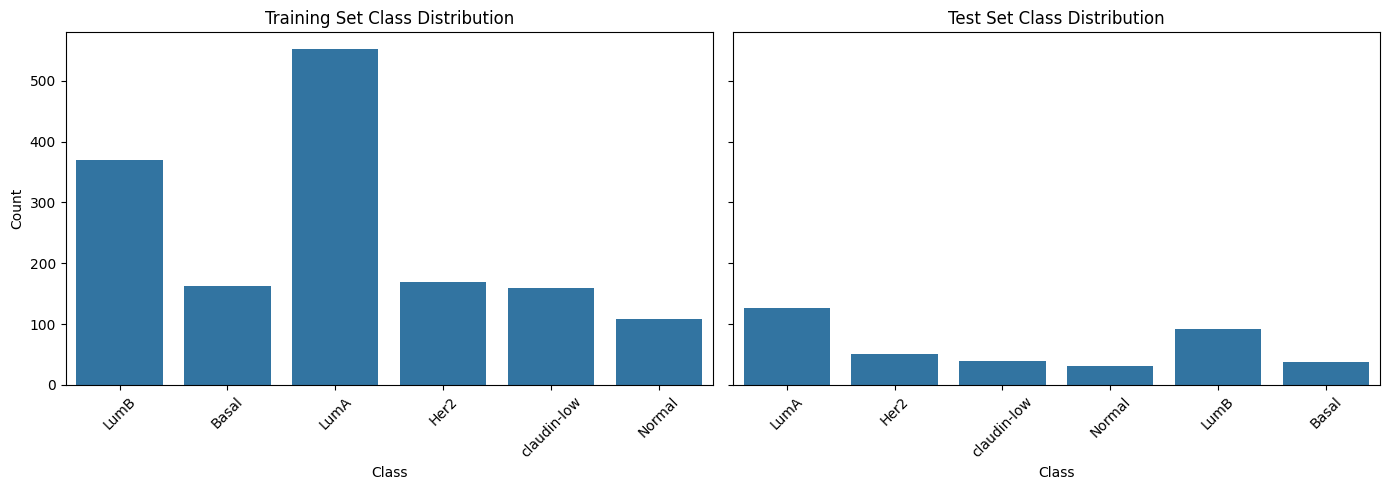

In [ ]:
# Plot side-by-side class distributions
target_col = 'pam50_+_claudin-low_subtype'
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.countplot(x=train_df[target_col], ax=axes[0])
axes[0].set_title("Training Set Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x=test_df[target_col], ax=axes[1])
axes[1].set_title("Test Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Separate features and target

In [ ]:
X_train = train_df.drop(columns=['pam50_+_claudin-low_subtype'])
y_train = train_df['pam50_+_claudin-low_subtype']

X_test = test_df.drop(columns=['pam50_+_claudin-low_subtype'])
y_test = test_df['pam50_+_claudin-low_subtype']

In [ ]:
# Compute balanced sample weights
sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights_test = compute_sample_weight(class_weight='balanced', y=y_test)

# Encode labels

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Define hyperparameter grid

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define hyperparameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'roc_auc_ovr': 'roc_auc_ovr'
    }

# Perform DT

In [ ]:
# Model and Random Search
param_grid = param_grid_dt

dt = DecisionTreeClassifier(random_state=42)

search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_grid,
    n_iter=30, # Increased iterations for broader search
    scoring=scoring,
    refit='roc_auc_ovr',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit with sample weights
search.fit(X_train, y_train, sample_weight=sample_weights_train)
best_model = search.best_estimator_

# Build table with results
cv_results_df = pd.DataFrame(search.cv_results_)
cv_results_df[['params', 'mean_test_accuracy', 'mean_test_f1_weighted', 'mean_test_roc_auc_ovr']].sort_values(by='mean_test_roc_auc_ovr', ascending=False).head()

,params,mean_test_accuracy,mean_test_f1_weighted,mean_test_roc_auc_ovr
17,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.552918,0.564071,0.847264
2,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.508902,0.524124,0.835983
11,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.585820,0.599431,0.835905
9,"{'min_samples_split': 2, 'min_samples_leaf': 1...",0.588393,0.593823,0.834298
21,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.607478,0.613160,0.828794


# Decode/Predictions

In [ ]:
# Predict
y_pred = best_model.predict(X_test)

# Decode predictions and test back to original labels
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# Confusion matrix

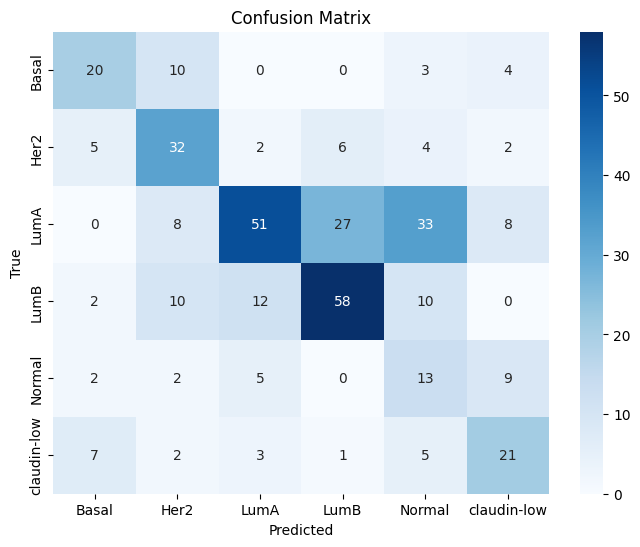

In [ ]:
labels = le.classes_
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report

In [ ]:
def evaluate_model(model, X_test, y_test, labels, sample_weights=None):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, sample_weight=sample_weights, target_names=labels))
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted', sample_weight=sample_weights)
    print(f"Weighted AUROC: {auc:.4f}")

evaluate_model(best_model, X_test, y_test, le.classes_) #, sample_weights=sample_weights_test)


Classification Report:
              precision    recall  f1-score   support

       Basal       0.56      0.54      0.55        37
        Her2       0.50      0.63      0.56        51
        LumA       0.70      0.40      0.51       127
        LumB       0.63      0.63      0.63        92
      Normal       0.19      0.42      0.26        31
 claudin-low       0.48      0.54      0.51        39

    accuracy                           0.52       377
   macro avg       0.51      0.53      0.50       377
weighted avg       0.58      0.52      0.53       377

Weighted AUROC: 0.8379


In [ ]:
print(le.classes_)

['Basal' 'Her2' 'LumA' 'LumB' 'Normal' 'claudin-low']


# AUROC Plot

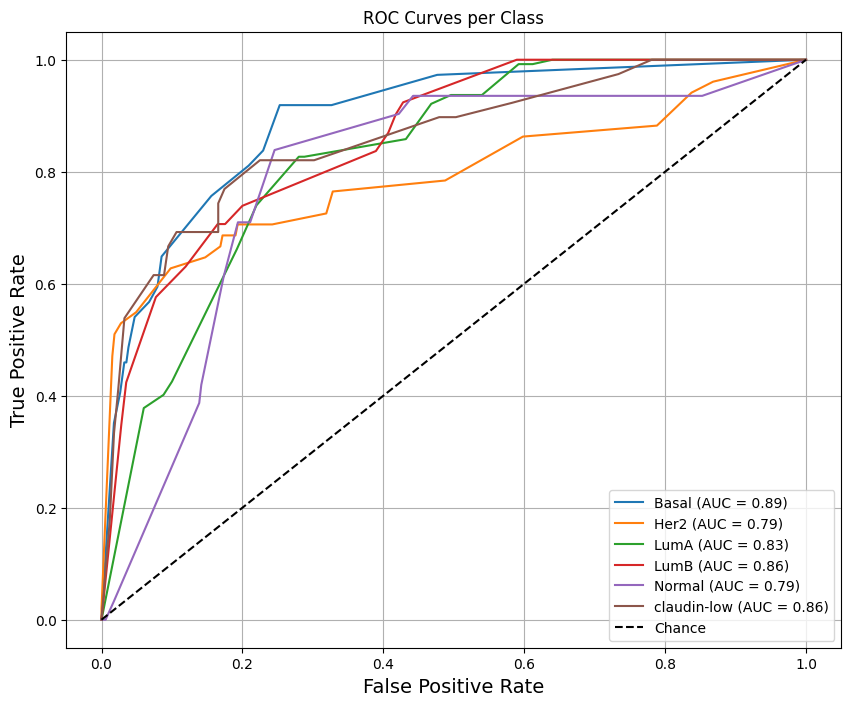

In [ ]:
y_score = best_model.predict_proba(X_test)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# SHAP analysis for DT

  0%|          | 0/300 [00:00<?, ?it/s]

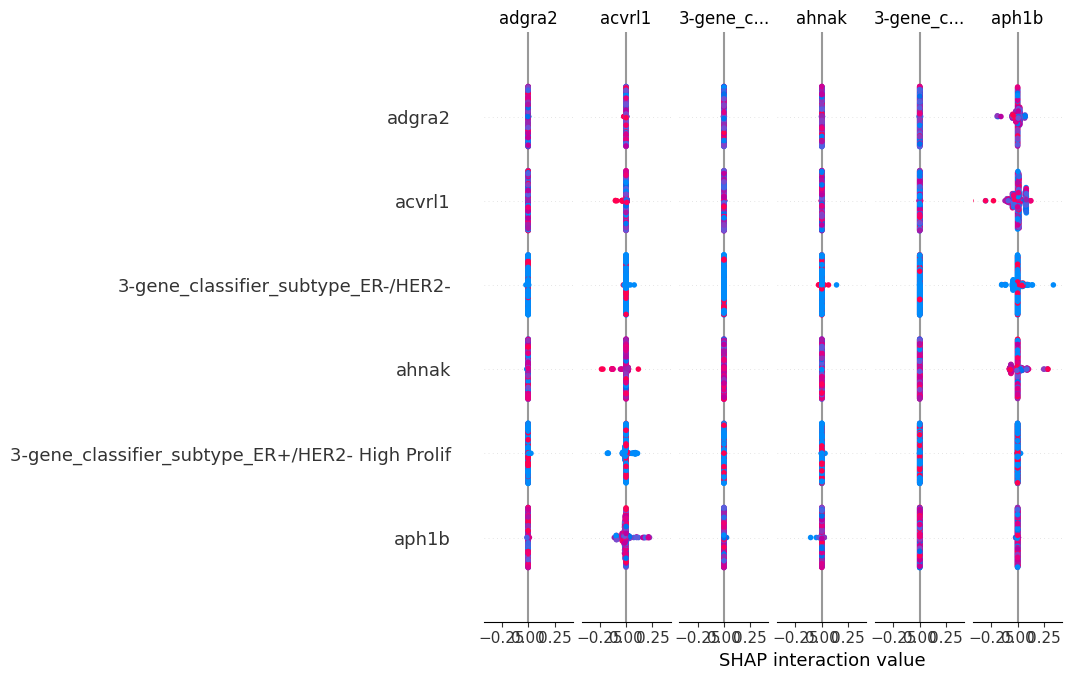

In [ ]:
import shap

# Create a SHAP explainer object
# shap.TreeExplainer does not support multiclass GradientBoostingClassifier
# Using KernelExplainer instead, which supports multiclass but is slower
# To speed up, we'll use a smaller sample of the test data

# Select a smaller sample of the test data
X_test_sample = X_test.sample(n=300, random_state=42) # You can adjust the sample size

explainer = shap.KernelExplainer(best_model.predict_proba, X_test_sample)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_sample)

# Summarize plot for all classes
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns, class_names=le.classes_)

In [ ]:
print(f'shap_values shape: {shap_values.shape}')
print(f'X_test_sample shape: {X_test_sample.shape}')
print(f'X_test shape: {X_test.shape}')

shap_values shape: (300, 50, 6)
X_test_sample shape: (300, 50)
X_test shape: (377, 50)


In [ ]:
len(shap_values)

300

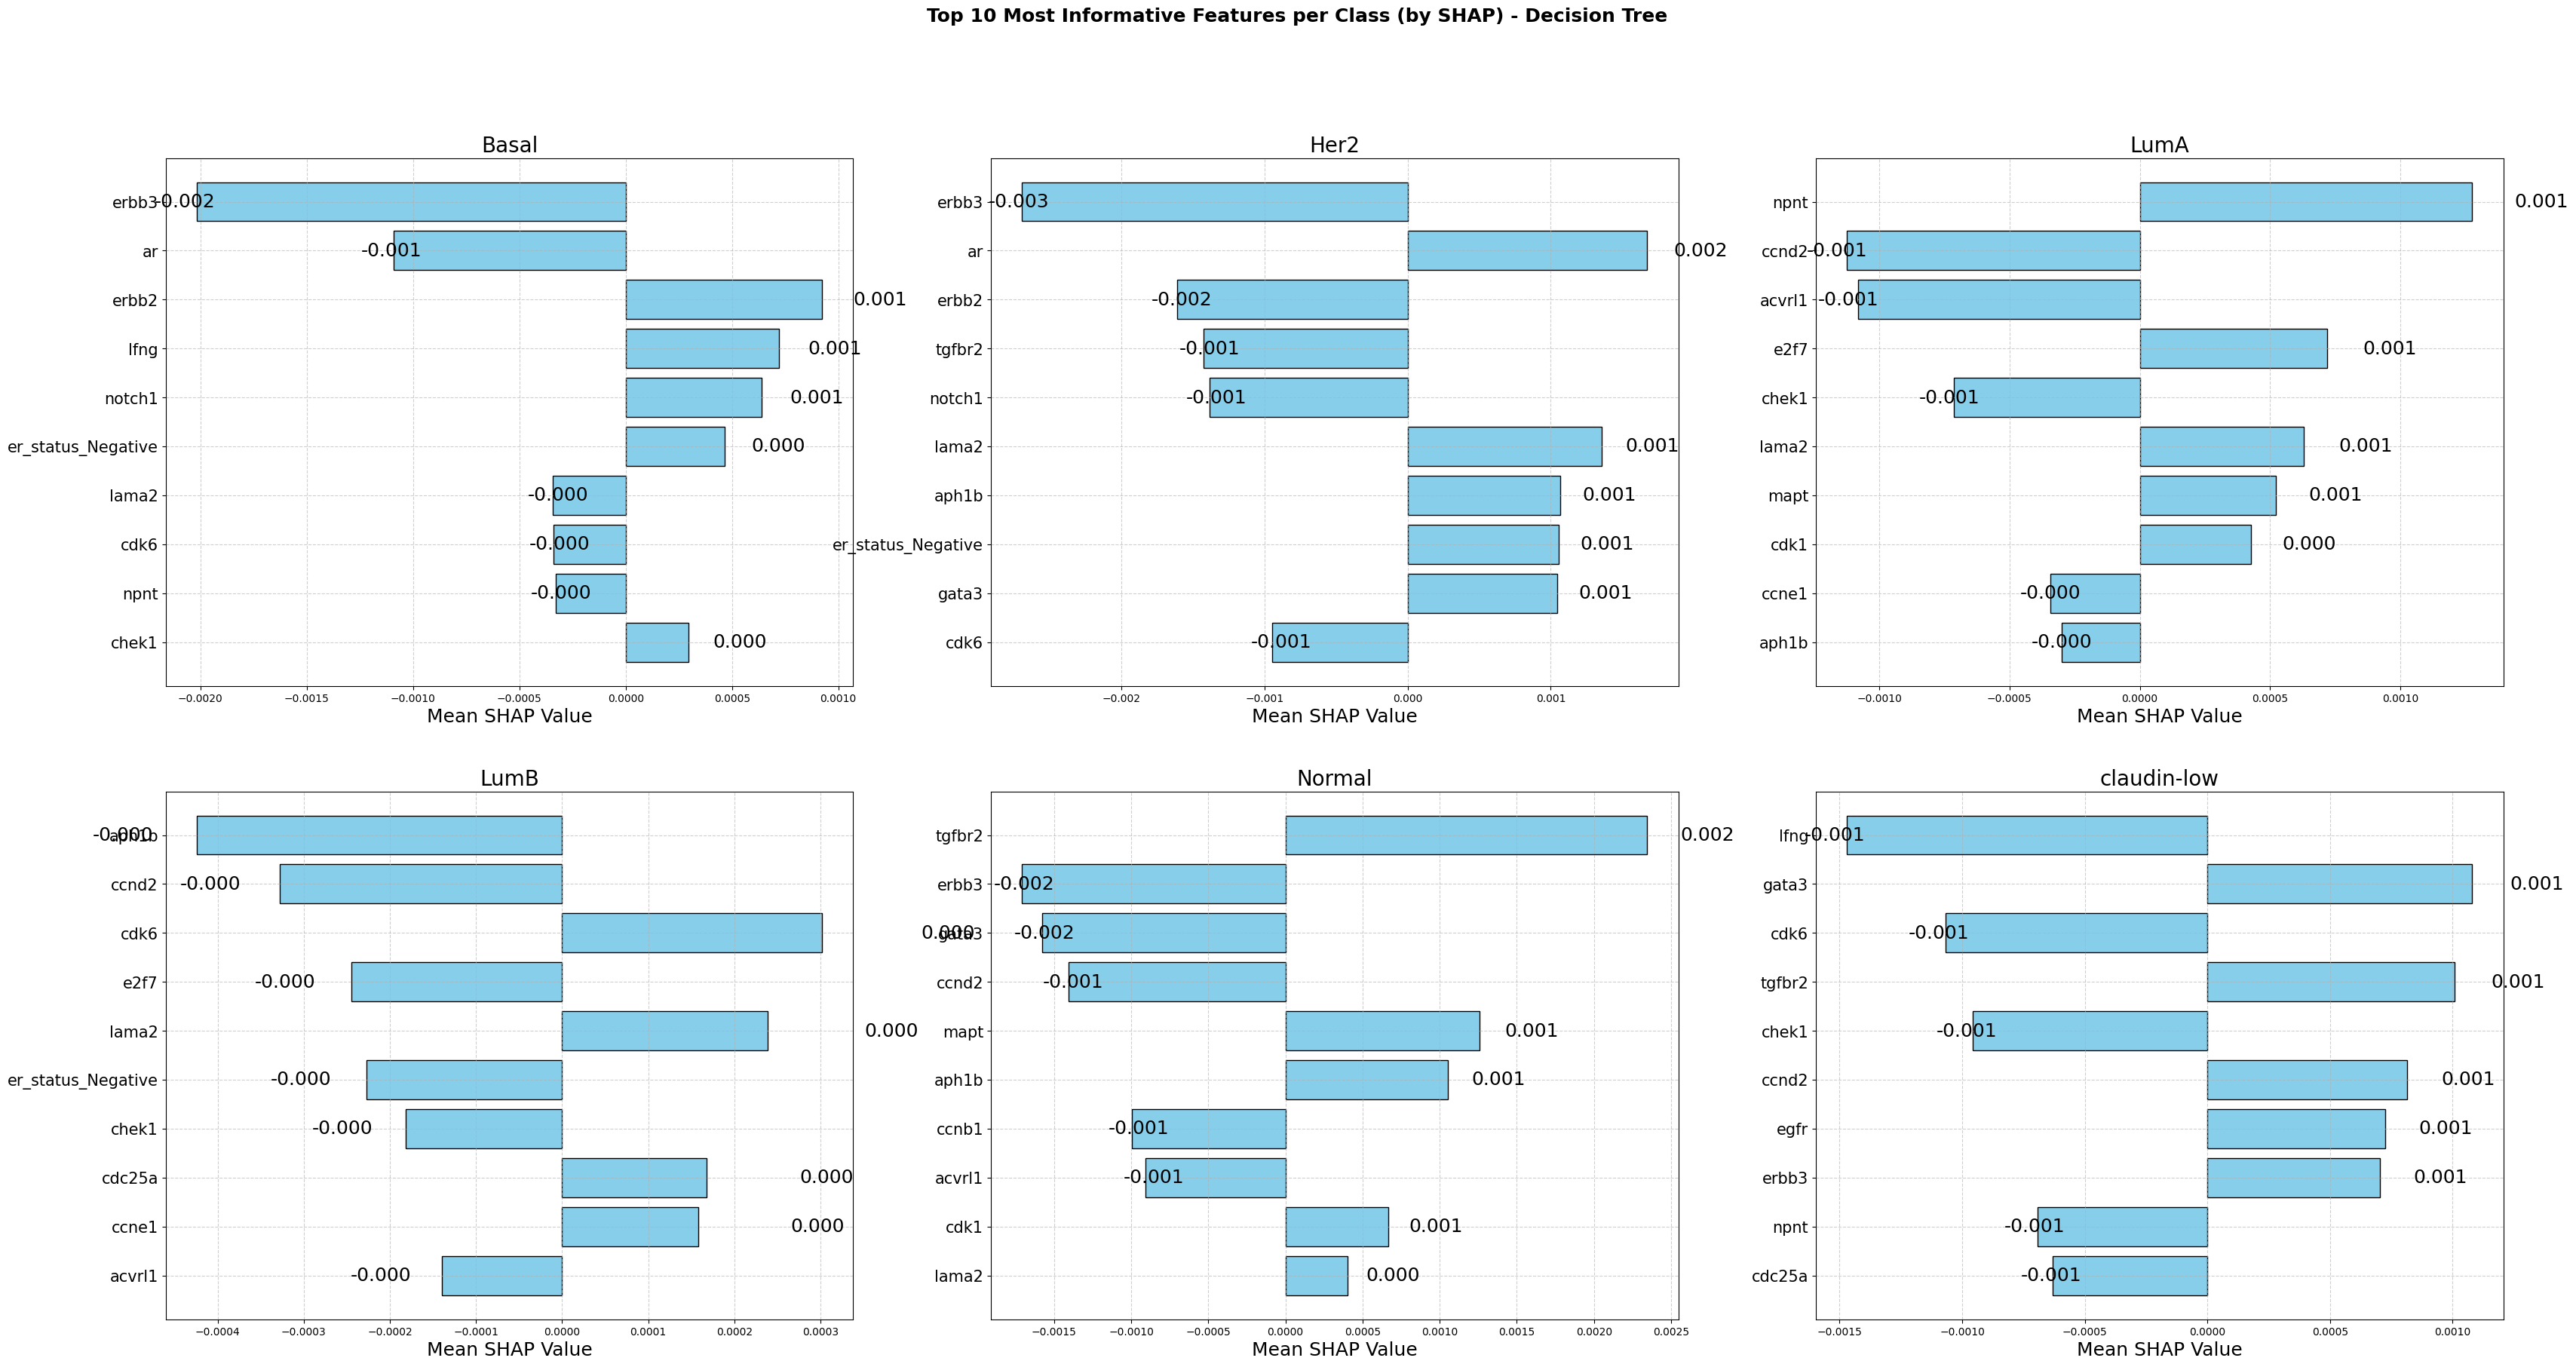

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Assume shap_values has shape (n_samples, n_features, n_classes)
n_samples, n_features, n_classes = shap_values.shape

# Use column names if X_test_sample is a DataFrame, else make generic names
feature_names = (
    X_test_sample.columns
    if hasattr(X_test_sample, 'columns')
    else [f"feature_{i}" for i in range(n_features)]
)

# Function to wrap long feature names into multiple lines
def wrap_labels(labels, width=15):
    wrapped = []
    for label in labels:
        wrapped_label = "\n".join(textwrap.wrap(label, width=width))
        wrapped.append(wrapped_label)
    return wrapped

# Class labels from LabelEncoder
class_labels = le.classes_

# Create subplots
n_rows, n_cols = 2, 3  # for 6 classes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 20))
axes = np.array(axes).ravel()

for class_idx in range(n_classes):
    ax = axes[class_idx]

    # Extract SHAP values for class `class_idx`
    class_shap = shap_values[:, :, class_idx]

    # Compute mean SHAP value and mean absolute SHAP value
    shap_avg = np.mean(class_shap, axis=0)
    shap_abs_avg = np.abs(shap_avg)

    # Get top 10 feature indices by abs(mean shap)
    sorted_idx = np.argsort(shap_abs_avg)[-10:]
    top_features = [feature_names[i] for i in sorted_idx]
    top_values = shap_avg[sorted_idx]

    # Wrap long feature names for better display
    top_features_wrapped = wrap_labels(top_features, width=20)

    # Plot
    bars = ax.barh(top_features_wrapped, top_values, color='skyblue', edgecolor='black')
    ax.set_title(f"{class_labels[class_idx]}", fontsize=20)
    ax.set_xlabel("Mean SHAP Value", fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Annotate bars
    for bar in bars:
        width = bar.get_width()
        offset = 0.05 * abs(width) + 1e-4  # dynamic spacing
        ax.text(
            width + np.sign(width) * offset,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.3f}", va='center', fontsize=18
        )

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=15)

# Hide unused subplots if any
for j in range(n_classes, n_rows * n_cols):
    fig.delaxes(axes[j])

# plt.tight_layout(rect=[0, 0, 1, 0.95])  # optionally uncomment to avoid overlaps
plt.suptitle("Top 10 Most Informative Features per Class (by SHAP) - Decision Tree", fontsize=18, weight='bold')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Compute mean SHAP value per feature per class: shape (n_features, n_classes)
mean_shap_per_class = np.mean(shap_values, axis=0)  # averages over samples (axis=0)

# Create DataFrame
mean_shap_df = pd.DataFrame(
    mean_shap_per_class,          # shape (n_features, n_classes)
    index=feature_names,          # feature names as row index
    columns=le.classes_           # class names as columns
)

mean_shap_df

,Basal,Her2,LumA,LumB,Normal,claudin-low
3-gene_classifier_subtype_ER+/HER2- High Prolif,-0.000003,-0.000002,7.606428e-06,0.000029,0.000000e+00,0.000009
3-gene_classifier_subtype_ER-/HER2-,0.000002,0.000000,3.129815e-05,-0.000002,-3.286055e-06,0.000079
acvrl1,-0.000198,0.000139,-1.081914e-03,-0.000139,-9.061159e-04,0.000286
adgra2,0.000106,-0.000026,-1.059664e-05,-0.000005,-2.248010e-05,0.000010
ahnak,0.000069,0.000238,-8.207611e-06,0.000023,0.000000e+00,-0.000309
aph1b,0.000127,0.001068,-3.009834e-04,-0.000424,1.051384e-03,-0.000491
ar,-0.001092,0.001672,-1.839871e-05,-0.000039,4.421817e-05,-0.000204
aurka,0.000018,0.000027,-2.497546e-05,0.000039,0.000000e+00,0.000011
bcl2,0.000034,0.000000,-3.309794e-06,-0.000013,-3.770085e-06,0.000032
bmpr1b,0.000033,0.000000,-4.902472e-06,0.000015,1.577761e-05,0.000042


Classes (breast cancer subtypes):
['Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'claudin-low']

Aggressive subtypes (from literature): Basal, claudin-low

Top 3 features for subtype 'Basal':
erbb3    0.002017
ar       0.001092
erbb2    0.000923
Name: Basal, dtype: float64

Top 3 features for subtype 'Her2':
erbb3    0.002693
ar       0.001672
erbb2    0.001611
Name: Her2, dtype: float64

Top 3 features for subtype 'LumA':
npnt      0.001275
ccnd2     0.001123
acvrl1    0.001082
Name: LumA, dtype: float64

Top 3 features for subtype 'LumB':
aph1b    0.000424
ccnd2    0.000328
cdk6     0.000302
Name: LumB, dtype: float64

Top 3 features for subtype 'Normal':
tgfbr2    0.002344
erbb3     0.001708
gata3     0.001579
Name: Normal, dtype: float64

Top 3 features for subtype 'claudin-low':
lfng     0.001469
gata3    0.001080
cdk6     0.001067
Name: claudin-low, dtype: float64


Top feature SHAP values across all classes:

Mean SHAP values of feature 'erbb3' across all subtypes:
Basal         -0

,Basal,Her2,LumA,LumB,Normal,claudin-low
Top 1,erbb3,erbb3,npnt,aph1b,tgfbr2,lfng
Top 2,ar,ar,ccnd2,ccnd2,erbb3,gata3
Top 3,erbb2,erbb2,acvrl1,cdk6,gata3,cdk6


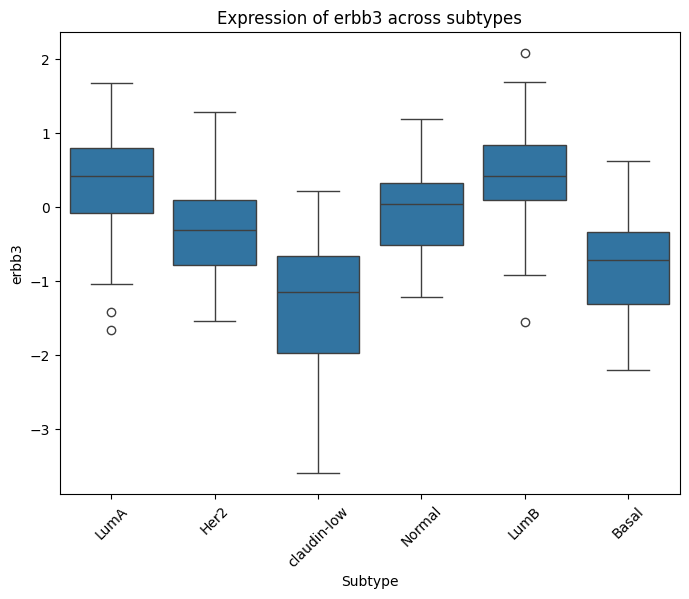

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Classes (breast cancer subtypes):")
print(mean_shap_df.columns.tolist())
print("\nAggressive subtypes (from literature): Basal, claudin-low\n")

top_features_by_class = {}

for class_name in mean_shap_df.columns:
    # Sort by absolute mean SHAP values descending, take top 3 features
    top_feats = mean_shap_df[class_name].abs().sort_values(ascending=False).head(3)
    top_features_by_class[class_name] = top_feats.index.tolist()
    print(f"Top 3 features for subtype '{class_name}':")
    print(top_feats)
    print()

print("\nTop feature SHAP values across all classes:")
for class_name in mean_shap_df.columns:
    top_feature = top_features_by_class[class_name][0]
    print(f"\nMean SHAP values of feature '{top_feature}' across all subtypes:")
    print(mean_shap_df.loc[top_feature])
    print()

# Create a summary table of top features per class
markers_table = pd.DataFrame.from_dict(top_features_by_class, orient='index').T
markers_table.index = ['Top 1', 'Top 2', 'Top 3']
print("Summary: Top marker features for each subtype:")
display(markers_table)

# Optional boxplot of expression for top gene in 'Basal' subtype
try:
    gene = top_features_by_class['Basal'][0]  # change 'Basal' if needed
    plot_df = X_test.copy()
    plot_df['Subtype'] = le.inverse_transform(y_test)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Subtype', y=gene, data=plot_df)
    plt.title(f"Expression of {gene} across subtypes")
    plt.xticks(rotation=45)
    plt.show()
except Exception as e:
    print(f"Optional plot skipped (reason: {e})")


Top marker features per class (class names):
Basal: ['erbb3', 'ar', 'erbb2', 'lfng', 'notch1', 'er_status_Negative']
Her2: ['erbb3', 'ar', 'erbb2', 'tgfbr2', 'notch1', 'lama2']
LumA: ['npnt', 'ccnd2', 'acvrl1', 'e2f7', 'chek1', 'lama2']
LumB: ['aph1b', 'ccnd2', 'cdk6', 'e2f7', 'lama2', 'er_status_Negative']
Normal: ['tgfbr2', 'erbb3', 'gata3', 'ccnd2', 'mapt', 'aph1b']
claudin-low: ['lfng', 'gata3', 'cdk6', 'tgfbr2', 'chek1', 'ccnd2']

Class mapping (int label → class name): {0: 'Basal', 1: 'Her2', 2: 'LumA', 3: 'LumB', 4: 'Normal', 5: 'claudin-low'}

Class name for Basal-like: Basal, Claudin-low: claudin-low

Top Basal-like markers (Basal): ['erbb3', 'ar', 'erbb2', 'lfng', 'notch1', 'er_status_Negative']
Top Claudin-low markers (claudin-low): ['lfng', 'gata3', 'cdk6', 'tgfbr2', 'chek1', 'ccnd2']

Basal-like marker feature SHAP values across all classes:


,erbb3,ar,erbb2,lfng,notch1,er_status_Negative
Basal,-0.002017,-0.001092,9.232864e-04,0.000721,0.000641,0.000466
Her2,-0.002693,0.001672,-1.610593e-03,-0.000007,-0.001380,0.001054
LumA,-0.000058,-0.000018,-4.883848e-07,-0.000018,-0.000021,0.000135
LumB,0.000016,-0.000039,6.387484e-05,0.000026,0.000002,-0.000227
Normal,-0.001708,0.000044,1.122119e-04,0.000354,-0.000007,0.000350
claudin-low,0.000705,-0.000204,5.492171e-04,-0.001469,0.000188,0.000511



Claudin-low marker feature SHAP values across all classes:


,lfng,gata3,cdk6,tgfbr2,chek1,ccnd2
Basal,0.000721,0.000170,-0.000339,-0.000187,0.000297,-0.000038
Her2,-0.000007,0.001045,-0.000946,-0.001424,-0.000696,-0.000709
LumA,-0.000018,-0.000036,0.000077,0.000003,-0.000713,-0.001123
LumB,0.000026,0.000018,0.000302,0.000047,-0.000181,-0.000328
Normal,0.000354,-0.001579,-0.000173,0.002344,-0.000008,-0.001406
claudin-low,-0.001469,0.001080,-0.001067,0.001008,-0.000956,0.000814



Feature expression patterns for Basal markers:


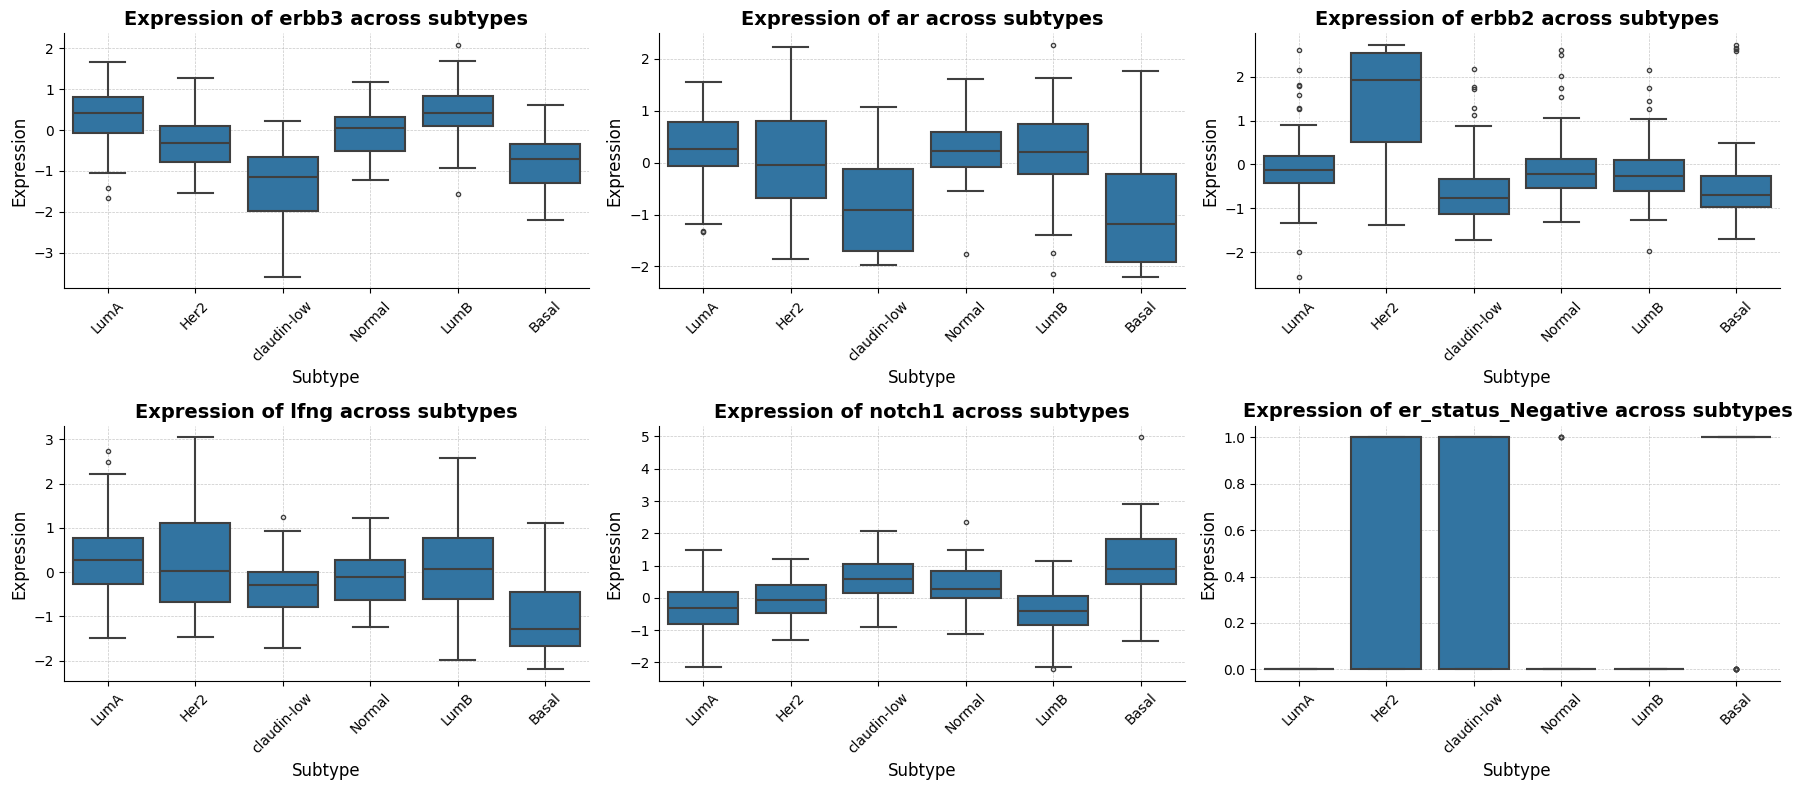


Feature expression patterns for claudin-low markers:


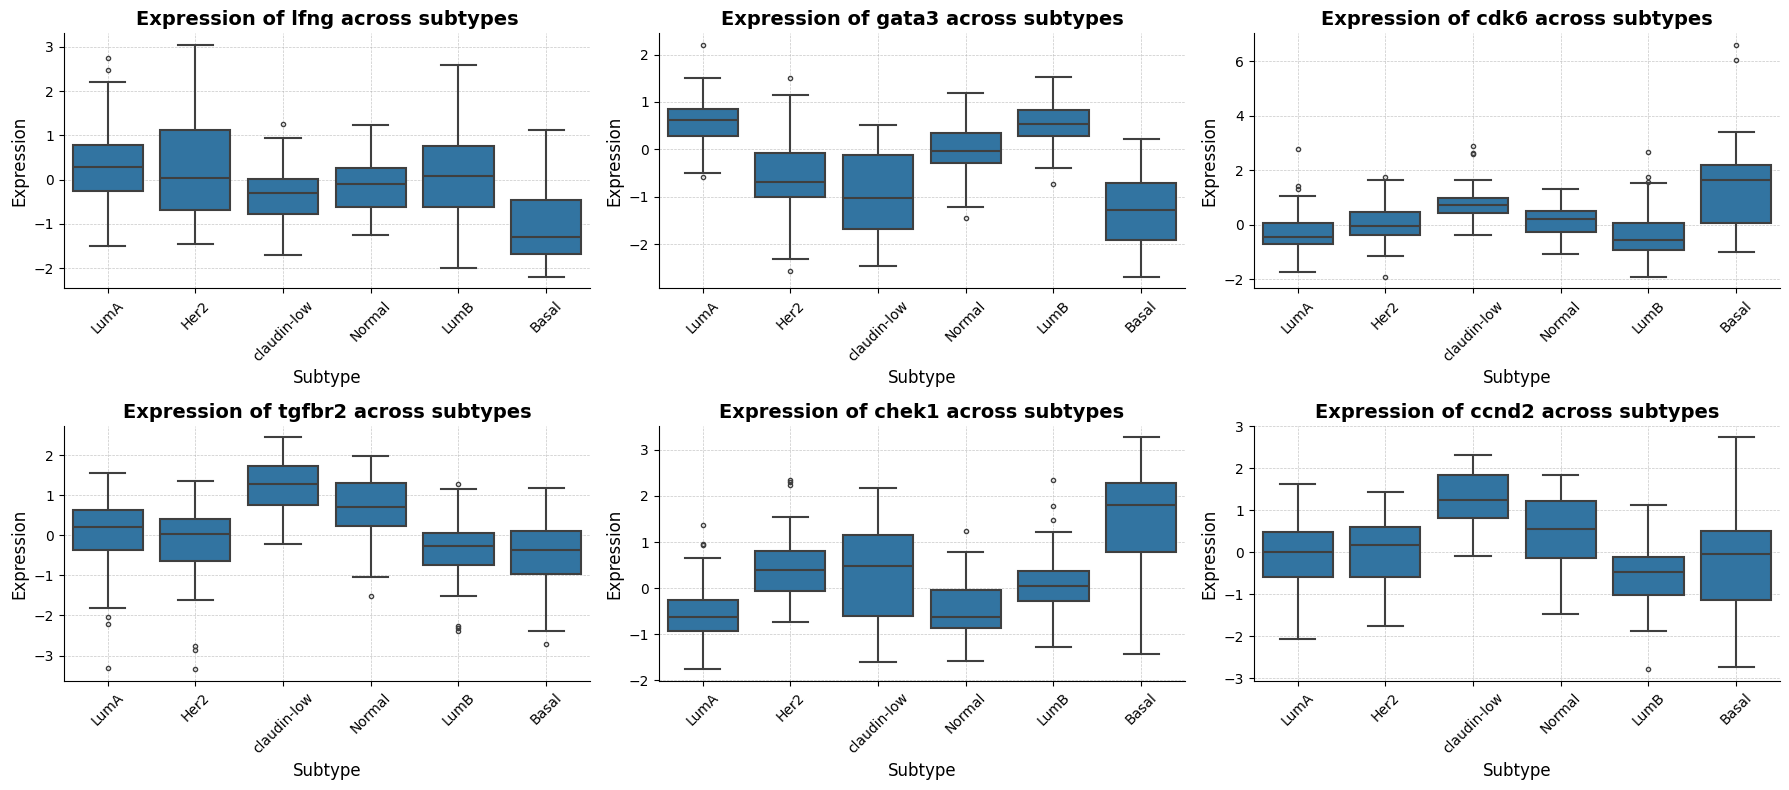


Biological summary for Basal markers:

- **erbb3**: negative impact in Basal (mean SHAP: -0.00202); highest in claudin-low, lowest in Her2. Consider literature for biological relevance.
- **ar**: negative impact in Basal (mean SHAP: -0.00109); highest in Her2, lowest in Basal. Consider literature for biological relevance.
- **erbb2**: positive impact in Basal (mean SHAP: 0.00092); highest in Basal, lowest in Her2. Consider literature for biological relevance.
- **lfng**: positive impact in Basal (mean SHAP: 0.00072); highest in Basal, lowest in claudin-low. Consider literature for biological relevance.
- **notch1**: positive impact in Basal (mean SHAP: 0.00064); highest in Basal, lowest in Her2. Consider literature for biological relevance.
- **er_status_Negative**: positive impact in Basal (mean SHAP: 0.00047); highest in Her2, lowest in LumB. Consider literature for biological relevance.

Biological summary for claudin-low markers:

- **lfng**: negative impact in claudin-low (mean S

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
N = 6  # top N markers per class

# Get top N marker features per class by absolute mean SHAP value
top_markers_by_class = {}
for cls in mean_shap_df.columns:
    shap_vals = mean_shap_df[cls]
    top_feats = shap_vals.abs().sort_values(ascending=False).head(N).index.tolist()
    top_markers_by_class[cls] = top_feats

print("Top marker features per class (class names):")
for cls, feats in top_markers_by_class.items():
    print(f"{cls}: {feats}")

# Map integer class labels back to class names (if needed)
int_to_class = dict(enumerate(le.classes_))
print("\nClass mapping (int label → class name):", int_to_class)

# Identify Basal-like and Claudin-low class names in your dataset
basal_col = None
claudin_col = None
for name in mean_shap_df.columns:
    if 'Basal' in name or 'basal' in name:
        basal_col = name
    if 'claudin' in name.lower():
        claudin_col = name

print(f"\nClass name for Basal-like: {basal_col}, Claudin-low: {claudin_col}")

# Get top markers for those classes
basal_markers = top_markers_by_class.get(basal_col, [])
claudin_markers = top_markers_by_class.get(claudin_col, [])

print(f"\nTop Basal-like markers ({basal_col}): {basal_markers}")
print(f"Top Claudin-low markers ({claudin_col}): {claudin_markers}")

def marker_shap_table(marker_list, shap_df):
    if not marker_list:
        print("No markers to show.")
        return pd.DataFrame()
    display_df = shap_df.loc[marker_list].T  # transpose to (classes x features)
    display(display_df)
    return display_df

print("\nBasal-like marker feature SHAP values across all classes:")
_ = marker_shap_table(basal_markers, mean_shap_df)

print("\nClaudin-low marker feature SHAP values across all classes:")
_ = marker_shap_table(claudin_markers, mean_shap_df)

# Prepare X_test DataFrame and labels for plotting if needed
X_test_df = pd.DataFrame(X_test, columns=feature_names) if not isinstance(X_test, pd.DataFrame) else X_test
y_test_labels = le.inverse_transform(y_test) if hasattr(le, "inverse_transform") else y_test

def plot_marker_expression(marker_features, X, y, palette=None, n_cols=3):
    if not marker_features:
        print("No marker features to plot.")
        return
    n_rows = int(np.ceil(len(marker_features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, feature in enumerate(marker_features):
        if feature not in X.columns:
            print(f"Feature {feature} not found in X columns, skipping.")
            continue

        plot_df = pd.DataFrame({feature: X[feature], 'Subtype': y})

        sns.boxplot(
            x='Subtype', y=feature, data=plot_df, ax=axes[i],
            palette=palette, linewidth=1.5, fliersize=3
        )

        axes[i].set_title(f'Expression of {feature} across subtypes', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Subtype', fontsize=12)
        axes[i].set_ylabel('Expression', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='both', labelsize=10)
        sns.despine(ax=axes[i])
        axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unused axes
    for i in range(len(marker_features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

if basal_markers:
    print(f"\nFeature expression patterns for {basal_col} markers:")
    plot_marker_expression(basal_markers, X_test_df, y_test_labels)
else:
    print(f"\nNo marker features found for {basal_col}. Skipping plot.")

if claudin_markers:
    print(f"\nFeature expression patterns for {claudin_col} markers:")
    plot_marker_expression(claudin_markers, X_test_df, y_test_labels)
else:
    print(f"\nNo marker features found for {claudin_col}. Skipping plot.")

def marker_report(markers, shap_df, class_name):
    lines = []
    for feature in markers:
        shap_vals = shap_df.loc[feature]
        main_val = shap_vals[class_name]
        highest = shap_vals.idxmax()
        lowest = shap_vals.idxmin()
        direction = "positive impact" if main_val > 0 else "negative impact"
        lines.append(
            f"- **{feature}**: {direction} in {class_name} (mean SHAP: {main_val:.5f}); " +
            f"highest in {highest}, lowest in {lowest}. " +
            f"Consider literature for biological relevance."
        )
    return "\n".join(lines)

if basal_markers:
    print(f"\nBiological summary for {basal_col} markers:\n")
    print(marker_report(basal_markers, mean_shap_df, basal_col))

if claudin_markers:
    print(f"\nBiological summary for {claudin_col} markers:\n")
    print(marker_report(claudin_markers, mean_shap_df, claudin_col))


Link to notes of genes and DT:
https://docs.google.com/document/d/1A0Xb0b_cbQCZy3h5ut1u2MHM_ZQ49PRFUYnUWhBKA54/edit?usp=drive_link
